# QuTiP Example: Steady State for an Optomechanical System in the Single-Photon Strong-Coupling Regime

P.D. Nation and J.R. Johansson

For more information about QuTiP see [http://qutip.org](http://qutip.org)

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from IPython.display import Image

In [5]:
from qutip import *

## Optomechanical Hamiltonian

The optomechanical Hamiltonian arrises from the radiation pressure interaction of light in an optical cavity where one of the cavity mirrors is mechanically compliant.

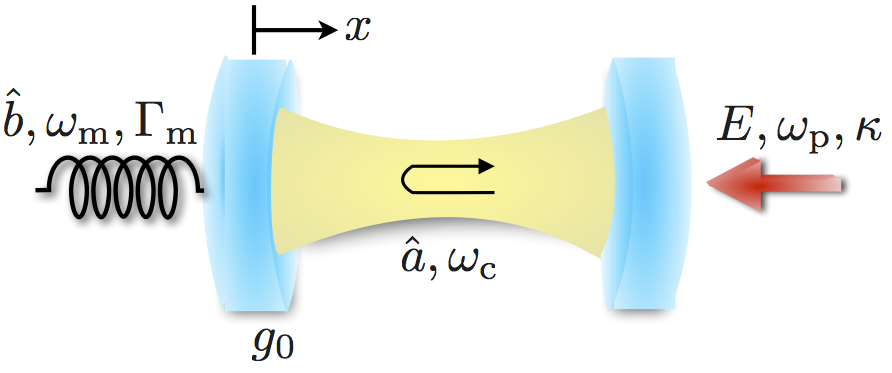

In [6]:
Image(filename='images/optomechanical_setup.png', width=500, embed=True)

Assuming that $a^{+}$, $a$ and $b^{+}$,$b$ are the raising and lowering operators for the cavity and mechanical oscillator, respectively, the Hamiltonian for an optomechanical system driven by a classical monochromatic pump term can be written as 

\begin{equation}
\frac{\hat{H}}{\hbar}=-\Delta\hat{a}^{+}\hat{a}+\omega_{m}\hat{b}^{+}\hat{b}+g_{0}(\hat{b}+\hat{b}^{+})\hat{a}^{+}\hat{a}+E\left(\hat{a}+\hat{a}^{+}\right),
\end{equation}

where $\Delta=\omega_{p}-\omega_{c}$ is the detuning between the pump ($\omega_{p}$) and cavity ($\omega_{c}$) mode frequencies, $g_{0}$ is the single-photon coupling strength, and $E$ is the amplitude of the pump mode. It is known that in the single-photon strong-coupling regime, where the cavity frequency shift per phonon is larger than the cavity line width, $g_{0}/\kappa \gtrsim 1$ where $\kappa$ is the decay rate of the cavity, and a single single photon displaces the mechanical oscillator by more than its zero-point amplitude $g_{0}/\omega_{m} \gtrsim 1$, or equiviently, $g^{2}_{0}/\kappa\omega_{m} \gtrsim 1$, the mechanical oscillator can be driven into a nonclassical steady state of the system$+$environment dynamics.  Here, we will use the steady state solvers in QuTiP to explore such a state and compare the various solvers.

## Solving for the Steady State Density Matrix

The steady state density matrix of the optomechanical system plus the environment can be found from the Liouvillian superoperator $\mathcal{L}$ via

\begin{equation}
\frac{d\rho}{dt}=\mathcal{L}\rho=0\rho,
\end{equation}

where $\mathcal{L}$ is typically given in Lindblad form
\begin{align}
\mathcal{L}[\hat{\rho}]=&-i[\hat{H},\hat{\rho}]+\kappa \mathcal{D}\left[\hat{a},\hat{\rho}\right]\\
&+\Gamma_{m}(1+n_{\rm{th}})\mathcal{D}[\hat{b},\hat{\rho}]+\Gamma_{m}n_{\rm th}\mathcal{D}[\hat{b}^{+},\hat{\rho}], \nonumber
\end{align}

where $\Gamma_{m}$ is the coulping strength of the mechanical oscillator to its thermal environment with average occupation number $n_{th}$.  As is customary, here we assume that the cavity mode is coupled to the vacuum.

Although, the steady state solution is nothing but an eigenvalue equation, the numerical solution to this equation is anything but trivial due to the non-Hermitian structure of $\mathcal{L}$ and its worsening condition number has the dimensionality of the truncated Hilbert space increases.

## Steady State Solvers in QuTiP v3.0+

As of QuTiP version 3.0, the following steady state solvers are available:

- **direct**: Direct LU factorization
- **eigen**: Calculates the eigenvector associated with the zero eigenvalue of $\mathcal{L}\rho$.
- **power**: Finds zero eigenvector using inverse-power method.
- **iterative-gmres**: Iterative solution via the GMRES solver.
- **iterative-lgmres**: Iterative solution via the LGMRES solver.
- **iterative-bicgstab**: Iterative solution via the BICGSTAB solver.
- **svd**: Solution via SVD decomposition (dense matrices only).

## Setup and Solution

### System Parameters

In [7]:
# System Parameters (in units of wm)
#-----------------------------------
Nc = 4                      # Number of cavity states
Nm = 80                     # Number of mech states
kappa = 0.3                 # Cavity damping rate
E = 0.1                     # Driving Amplitude         
g0 = 2.4*kappa              # Coupling strength
Qm = 1e4                    # Mech quality factor
gamma = 1/Qm                # Mech damping rate
n_th = 1                    # Mech bath temperature
delta = -0.43               # Detuning

### Build Hamiltonian and Collapse Operators

In [8]:
# Operators
#----------
a = tensor(destroy(Nc), qeye(Nm))
b = tensor(qeye(Nc), destroy(Nm))
num_b = b.dag()*b
num_a = a.dag()*a

# Hamiltonian
#------------
H = -delta*(num_a)+num_b+g0*(b.dag()+b)*num_a+E*(a.dag()+a)

# Collapse operators
#-------------------
cc = np.sqrt(kappa)*a
cm = np.sqrt(gamma*(1.0 + n_th))*b
cp = np.sqrt(gamma*n_th)*b.dag()
c_ops = [cc,cm,cp]

### Run Steady State Solvers

In [20]:
solvers = ['direct','eigen','power','iterative-gmres','iterative-bicgstab']
mech_dms = []

for ss in solvers:
    if ss in ['iterative-gmres','iterative-bicgstab']:
        use_rcm = True
    else:
        use_rcm = False
    rho_ss, info = steadystate(H, c_ops, method=ss,use_precond=True, 
                use_rcm=use_rcm, tol=1e-15, return_info=True)
    print(ss,'solution time =',info['solution_time'])
    rho_mech = ptrace(rho_ss, 1)
    mech_dms.append(rho_mech)
mech_dms = np.asarray(mech_dms)

direct solution time = 23.896480083465576
eigen solution time = 383.4311008453369
power solution time = 13.483030796051025
iterative-gmres solution time = 142.33112359046936
iterative-bicgstab solution time = 239.15512800216675


### Check Consistancy of Solutions

Can check to see if the solutions are the same by looking at the number of nonzero elements (NNZ) in the difference between mechanical density matrices.

In [21]:
for kk in range(len(mech_dms)):
    print((mech_dms[kk]-mech_dms[0]).data.nnz)

0
98
0
0
0


It seems that the eigensolver solution is not exactly the same.  Lets check the magnitude of the elements to see if they are small.

In [22]:
for kk in range(len(mech_dms)):
    print(any(abs((mech_dms[kk] - mech_dms[0]).data.data)>1e-11))

False
False
False
False
False


## Plot the Mechanical Oscillator Wigner Function

It is known that the density matrix for the mechanical oscillator is diagoinal in the Fock basis due to phase diffusion.  However some small off-diagonal terms show up during the factorization process

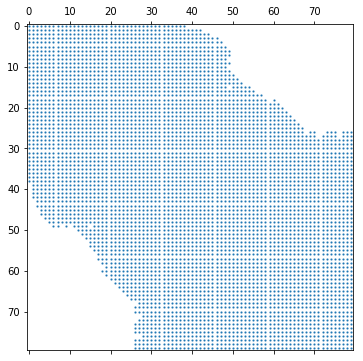

In [23]:
fig = plt.figure(figsize=(8,6))
plt.spy(rho_mech.data, ms=1);

Therefore, to remove this error, let use explicitly take the diagonal elements are form a new operator out of them

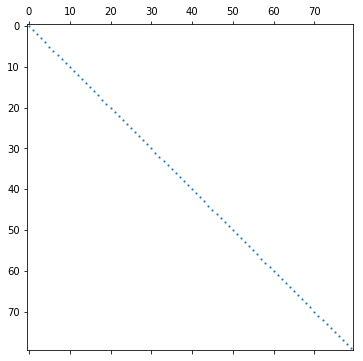

In [24]:
diag = rho_mech.diag()
rho_mech2 = qdiags(diag, 0, dims=rho_mech.dims, shape=rho_mech.shape)
fig = plt.figure(figsize=(8,6))
plt.spy(rho_mech2.data, ms=1);

Now lets compute the oscillator Wigner function and plot it to see if there are any regions of negativity.

In [32]:
xvec = np.linspace(-20, 20, 256)
W = wigner(rho_mech2, xvec, xvec)
wmap = wigner_cmap(W, shift=-1e-5)

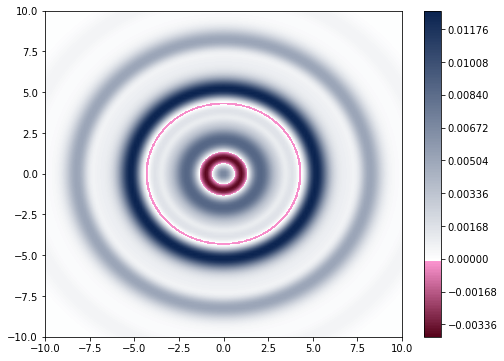

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
c = ax.contourf(xvec, xvec, W, 256, cmap=wmap)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
plt.colorbar(c, ax=ax);

## Versions

In [27]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.3.0.dev0+6e5b1d43
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.25.2
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.2 |Anaconda custom (x86_64)| (default, Jul 20 2017, 13:14:59) [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]"
OS,posix [darwin]
